In [13]:
from btm import BitermTopicModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from scipy import stats

# Data Loading

In [2]:
df = pd.read_csv("data/reddit2017.csv", header=0, encoding='latin1')

selected_domains = ["foxnews.com", 
                    "bbc.com", 
                    "bloomberg.com",
                    "reuters.com",
                    "cnn.com",
                    "cbc.ca",
                    "dw.com",
                    "independent.co.uk",
                    "theguardian.com",
                    "nytimes.com",
                    "rt.com",
                    "washingtonpost.com"]

df["Domain"] = df["Domain"].replace("bbc.co.uk","bbc.com")
df["Domain"] = df["Domain"].replace("uk.reuters.com","reuters.com")
df["Domain"] = df["Domain"].replace("edition.cnn.com","cnn.com")
df["Domain"] = df["Domain"].replace("theguardian.co.uk","theguardian.com")

In [3]:
df

,Created,Domain,Title
0,1.495617e+09,reuters.com,Trump hires private attorney for Russia probe
1,1.495611e+09,theguardian.com,Study finds mushrooms are the safest recreatio...
2,1.495622e+09,huffingtonpost.co.uk,Isis Flag Raised In Philippines As Militants '...
3,1.495620e+09,news.antiwar.com,Israeli Troops Shoot and Wound 11 Palestinian ...
4,1.495622e+09,peacecorpsconnect.org,President Proposes Largest Cut to Peace Corps ...
5,1.495609e+09,npr.org,"ISIS linked group takes over Marawi City, Phil..."
6,1.495611e+09,reuters.com,China urges North Korea not to violate U.N. re...
7,1.495614e+09,amp.cnn.com,UK will deploy soldiers to take over guard dut...
8,1.495610e+09,engadget.com,Microsoft made a version of Windows 10 for the...
9,1.495617e+09,themoscowtimes.com,Russian Bishop Says Jesus Would Have Accepted ...


In [4]:
selected_headlines = df[df["Domain"].isin(selected_domains)]
selected_headlines = selected_headlines.reset_index()

In [5]:
un, counts = np.unique(selected_headlines["Domain"].as_matrix(), return_counts=True)
print(un, counts)

['bbc.com' 'bloomberg.com' 'cbc.ca' 'cnn.com' 'dw.com' 'foxnews.com'
 'independent.co.uk' 'nytimes.com' 'reuters.com' 'rt.com' 'theguardian.com'
 'washingtonpost.com'] [3228  436  441 1018  604  381 2046  482 4160  572 2288  394]


In [6]:
# Tokenization
def title_to_words( raw_title ):
    title_text = BeautifulSoup(raw_title).get_text()     
    letters_only = re.sub("[^a-zA-Z]", " ", title_text)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return( " ".join( meaningful_words ))

In [7]:
tokenized = []
for headline in selected_headlines['Title']:
    tokenized.append( title_to_words( headline ) )

C:\Users\Timo\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\Timo\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


# Topic Detection

In [8]:
def get_topics_for_docs(documents):
    with open('headlines2017.txt') as f:
        doc=f.read()

    vocab_size = 5000
    alpha = 1
    beta = 0.1
    
    headlines = doc.split('\n')
    unique_headlines = [item for item, count in Counter(headlines).items() if count == 1]
    split = [headline.split(" ") for headline in unique_headlines]
    
    btm = BitermTopicModel(split, vocab_size)
    btm.load_params('btm_params_2017.npz')
    for i, topic in enumerate(btm.get_topic_words(words_per_topic=20)):
        print("Topic {}: ".format(i), topic)
    
    tokenized_docs = [doc.split(" ") for doc in documents]
    
    topic_probs = btm.get_topics_for_docs(tokenized_docs)
    
    # Some documents may return NaN probabilities
    nan_idxs = [i for i in range(len(topic_probs)) if type(topic_probs[i])!=list]
    valid_idxs = [i for i in range(len(topic_probs)) if type(topic_probs[i])==list]
    valid_probs = np.array(list(np.array(topic_probs)[valid_idxs]))
    
    topics_valid = np.argmax(valid_probs,axis=1)
    topics = np.zeros((len(topic_probs)),dtype=np.uint8)
    topics[nan_idxs] = -1
    topics[valid_idxs] = topics_valid
    return topics

In [9]:
topics = get_topics_for_docs(tokenized)

Topic 0:  ['election', 'eu', 'brexit', 'vote', 'party', 'president', 'minister', 'uk', 'may', 'parliament', 'presidential', 'theresa', 'says', 'prime', 'european', 'le', 'government', 'would', 'pen', 'french']
Topic 1:  ['russian', 'russia', 'us', 'intelligence', 'trump', 'hacking', 'hackers', 'u', 'attack', 'cyber', 'cia', 'fbi', 'security', 'government', 'former', 'ex', 'spy', 'data', 'says', 'officials']
Topic 2:  ['world', 'found', 'new', 'australia', 'near', 'north', 'sea', 'years', 'japan', 'plant', 'high', 'ocean', 'fukushima', 'scientists', 'south', 'city', 'fire', 'australian', 'nuclear', 'dead']
Topic 3:  ['germany', 'party', 'trump', 'right', 'says', 'german', 'nazi', 'world', 'anti', 'social', 'pope', 'new', 'election', 'far', 'brexit', 'leader', 'president', 'french', 'speech', 'saying']
Topic 4:  ['first', 'flight', 'china', 'flights', 'new', 'jet', 'air', 'london', 'passengers', 'airport', 'india', 'service', 'aircraft', 'plane', 'passenger', 'longest', 'flying', 'queen'

C:\Users\Timo\Documents\Uni\2016-2017\Language & Web Interaction\Final Project\git\btm.py:125: RuntimeWarning: invalid value encountered in double_scalars
  return [((np.sum(topic_prods_b,axis=0))/len(topic_prods_b)).tolist() for topic_prods_b in pzb]


 ['corruption', 'scandal', 'brazil', 'bribery', 'court', 'brazilian', 'president', 'temer', 'charges', 'arrest', 'political', 'samsung', 'park', 'allegations', 'trial', 'odebrecht', 'former', 'korean', 'korea', 'michel']
Topic 13:  ['killed', 'least', 'isis', 'attack', 'syria', 'mosul', 'near', 'forces', 'dead', 'kills', 'injured', 'islamic', 'people', 'iraqi', 'militants', 'dozens', 'civilians', 'suicide', 'syrian', 'bomb']
Topic 14:  ['korea', 'navy', 'south', 'china', 'u', 'military', 'japan', 'sea', 'korean', 'aircraft', 'north', 'missile', 'carrier', 'chinese', 'us', 'force', 'air', 'russian', 'missiles', 'japanese']
Topic 15:  ['ban', 'court', 'law', 'eu', 'rules', 'european', 'government', 'u', 'bill', 'companies', 'laws', 'could', 'new', 'uk', 'rights', 'legal', 'social', 'us', 'trump', 'travel']
Topic 16:  ['israel', 'trump', 'israeli', 'president', 'netanyahu', 'house', 'white', 'us', 'palestinian', 'donald', 'says', 'minister', 'jerusalem', 'bank', 'peace', 'palestinians', '

In [10]:
selected_topics = [0,1,3,10,16]

topic_idxs = []
for i in selected_topics:
    idxs = np.where(topics==i)[0]
    topic_idxs.append(idxs)
    print("Topic {}: {} headlines".format(i,len(idxs)))

Topic 0: 2319 headlines
Topic 1: 347 headlines
Topic 3: 321 headlines
Topic 10: 3442 headlines
Topic 16: 105 headlines


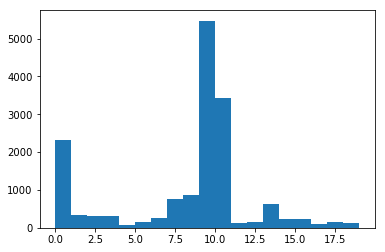

In [11]:
plt.hist(topics,bins=range(20))
plt.show()

In [15]:
sa = SentimentIntensityAnalyzer()

for i, topic in enumerate(selected_topics):
    compounds = []
    headlines = selected_headlines.ix[topic_idxs[i]]
    for headline in headlines['Title']:
        compound = sa.polarity_scores(headline)['compound']
        compounds.append(compound)
    
    mean_sentiment = np.mean(compounds)
    
    print("===== Topic {} =====".format(topic))
    print("  Number of articles: {}".format(len(topic_idxs[i])))
    print("  Average sentiment: {}".format(mean_sentiment))
    print("  Standard deviation: {}".format(np.std(compounds)))
    
    compounds_per_domain = []
    for domain in selected_domains:
        headlines_domain = headlines[headlines['Domain'] == domain]
        compounds_domain = []
        for headline in headlines_domain['Title']:
            compound_domain = sa.polarity_scores(headline)['compound']
            compounds_domain.append(compound_domain)
        mean_sentiment_domain = np.mean(compounds_domain)
        print("\t== Domain {} ==".format(domain))
        print("\t  Number of articles: {}".format(len(headlines_domain)))
        print("\t  Average sentiment: {}".format(mean_sentiment_domain))
        print("\t  Difference: {}".format(mean_sentiment_domain-mean_sentiment))
        print("\t  Standard deviation {}".format(np.std(compounds_domain)))
        compounds_per_domain.append(compounds_domain)
        
    for j in range(0,len(selected_domains)):
        for k in range(j+1, len(selected_domains)):
            t, p = stats.ttest_ind(compounds_per_domain[j], compounds_per_domain[k],equal_var=False)
            print("  T Test with {} and {}: t = {}, p = {}".format(selected_domains[j],selected_domains[k],t,p))
    print()

===== Topic 0 =====
  Number of articles: 2319
  Average sentiment: -0.04130991806813281
  Standard deviation: 0.3868118164901449
	== Domain foxnews.com ==
	  Number of articles: 21
	  Average sentiment: -0.08411428571428572
	  Difference: -0.04280436764615291
	  Standard deviation 0.3950931611486012
	== Domain bbc.com ==
	  Number of articles: 498
	  Average sentiment: -0.07212951807228916
	  Difference: -0.03081960000415635
	  Standard deviation 0.347168300956358
	== Domain bloomberg.com ==
	  Number of articles: 78
	  Average sentiment: 0.0754948717948718
	  Difference: 0.1168047898630046
	  Standard deviation 0.38131624935869646
	== Domain reuters.com ==
	  Number of articles: 545
	  Average sentiment: 0.026169357798165135
	  Difference: 0.06747927586629796
	  Standard deviation 0.3722152026687689
	== Domain cnn.com ==
	  Number of articles: 79
	  Average sentiment: -0.06897468354430378
	  Difference: -0.027664765476170965
	  Standard deviation 0.34761601522746527
	== Domain cbc.ca

C:\Users\Timo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\Timo\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Timo\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Timo\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Timo\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
